In [1]:
import sys
sys.path.append('../')
import sys
import os

# 获取最后添加的路径的绝对路径
absolute_path = os.path.abspath(sys.path[-1])

print("添加的绝对路径是:", absolute_path)

添加的绝对路径是: /liujinxin/lam/OE


In [2]:
import torch
import torch.nn as nn
from neuralop.models import FNO
import numpy as np
import re
import scipy
from torch.utils.data import Dataset, DataLoader
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm  # This imports the tqdm class for progress bars
from Operator import utilities3

plt.rc('font', family='STIXGeneral')

In [3]:

class OE_Dataset(Dataset):
    def __init__(self, input_data,input_cond,out,task="NCHD",**kwargs):
      

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_data = input_data.to(self.device) #[b, 1,1, 300] 时间维度已经在前面
        self.condition = input_cond
        self.ground_truth = out.to(self.device)# ground truth
        self.task = task
         #这里condition的是A和L 两个条件
        self.con_tensor=self.conditions_to_tensor()
    
       
        
    def __len__(self):
        
        return  self.input_data.shape[0]

    def __getitem__(self, idx):
    
       
        ini_data = self.input_data[idx] # ini_eta 
        ground_truth = self.ground_truth[idx]
        condition = self.con_tensor[idx] # condition,已经进入cuda
   
        
        return ini_data,condition,ground_truth
    
    def conditions_to_tensor(self):
       # 假设每个条件都有2个值（A和L）
        if self.task =="NCHD":# 2个条件
            
            tensor = torch.zeros((len(self.condition), 2), dtype=torch.float32).to(self.device)
       
        
        for i, (key, value) in enumerate(self.condition.items()):
            tensor[i, 0] = torch.tensor(value['A'], dtype=torch.float32)  # 第一个值是A
            tensor[i, 1] = torch.tensor(value['L'], dtype=torch.float32)  # 第二个值是L

        return tensor
#查找该目录里面所有.mat 文件 返回name list
def return_name_list(folder):
    # 初始化一个空列表，用于存储找到的.mat文件名
    name_list = []
    
    # os.walk遍历文件夹
    for dirpath, dirnames, filenames in os.walk(folder):
        # 遍历文件名
        for filename in filenames:
            # 检查文件扩展名是否为.mat
            if filename.endswith('.mat'):
                # 如果是，将文件名添加到列表中
                name_list.append(folder+"/"+filename)
                
    return name_list

   
class Read_Mat_4torch():
    def __init__(self, mat_file:list):
        
        self.mat_file = mat_file
        # 正则表达式模式
        self.CONDITIONS = {}
        self.datas = None  # 初始化datas为None
        for i,mat in enumerate(mat_file):
            pattern = r'A_([0-9.]+)_L_([0-9.]+)'

            # 搜索模式并提取数字
            match = re.search(pattern, mat)
            self.A = np.float32(match.group(1))
            self.L = np.float32(match.group(2))
            self.CONDITIONS[f"{mat}"]={ "A":self.A,
                                        "L":self.L}
        
    def _return_conditions(self):
        return self.CONDITIONS 

    def _read_mat(self):
        
        files = len(self.mat_file)
        self.datas= np.zeros((files,640,300,3))
        
        for i, mat in tqdm(enumerate(self.mat_file), total=len(self.mat_file), desc="Loading MAT files"):
            
            self.data = scipy.io.loadmat(mat)
            self.wave_data = self.data['wave_data'][0, 0]

            title = ["deepsea", "slope", "normal"]

            self.deepsea_data = self.wave_data['deepsea'].reshape(640, 100, 3).astype(np.float32)
            self.slope_data = self.wave_data['slope'].reshape(640, 100, 3).astype(np.float32)
            self.normal_data = self.wave_data['normal'].reshape(640, 100, 3).astype(np.float32)

            current_data = np.concatenate((self.deepsea_data, self.slope_data, self.normal_data), axis=1)
            self.datas[i] = current_data
            
            #tqdm.write(f"Processed {i+1}/{len(self.mat_file)} files")

        self.datas = torch.from_numpy(self.datas).float() #转torch
        self.datas = self.datas.permute(0,3,1,2) # 
        print("data shape",self.datas.shape)
  
        return self.datas,self.CONDITIONS

In [4]:
All_mat_file= return_name_list(folder="/liujinxin/lam/OE/Data/Train/NCHD")
# 打乱文件列表以确保随机性
np.random.shuffle(All_mat_file)

# 计算训练集的大小（70%）
train_size = int(len(All_mat_file) * 0.7)

# 分割列表为训练集和测试集
train_files = All_mat_file[:train_size]
test_files = All_mat_file[train_size:]

In [5]:
train_files

['/liujinxin/lam/OE/Data/Train/NCHD/A_0.020_L_6.56_dr_0.04_Time_scale_208.54984_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.015_L_7.06_dr_0.04_Time_scale_240.81261_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.020_L_6.08_dr_0.04_Time_scale_208.54984_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.010_L_4.90_dr_0.04_Time_scale_294.93401_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.015_L_5.82_dr_0.04_Time_scale_240.81261_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.020_L_4.04_dr_0.04_Time_scale_208.54984_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.015_L_1.76_dr_0.04_Time_scale_240.81261_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.010_L_4.22_dr_0.04_Time_scale_294.93401_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.015_L_5.40_dr_0.04_Time_scale_240.81261_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.025_L_7.62_dr_0.04_Time_scale_186.53264_wave_data.mat',
 '/liujinxin/lam/OE/Data/Train/NCHD/A_0.

In [35]:
from scipy.io import loadmat

# 替换为你的.mat文件的路径
train_torch_data,train_Conditions = Read_Mat_4torch(mat_file = train_files)._read_mat()

#***** 维度变化，输入【b,1,1,300】-> 输出[b,640,1,300]
#train
train_g_t = train_torch_data[:,2:3,:,:]# ground_truth torch.Size([b, 1,640, 300])
train_g_t = train_g_t.permute(0,2,1,3) #=[b,640,1,300]s
#####ini
train_input_data = train_g_t[:,0:1,0:1,:] # ini([b, 1,1, 300]) 0:1 iss time

Loading MAT files:  71%|███████   | 1124/1578 [00:24<00:08, 53.71it/s]

In [ ]:
gt_normalizer = utilities3.UnitGaussianNormalizer(train_g_t)
input_normalizer = utilities3.UnitGaussianNormalizer(train_input_data)

In [ ]:
# 替换为你的.mat文件的路径 
mat_file_path = 'A_0.030_L_9.60_dr_0.04_Time_scale_170.28023_wave_data.mat'
train_torch_data_big,train_Conditions_big = Read_Mat_4torch(mat_file = [mat_file_path])._read_mat()

#***** 维度变化，输入【b,1,1,300】-> 输出[b,640,1,300]
#train
train_g_t_big = train_torch_data_big[:,2:3,:,:]# ground_truth torch.Size([b, 1,640, 300])
train_g_t_big = train_g_t.permute(0,2,1,3) #=[b,640,1,300]s
#####ini
train_input_data_big = train_g_t[:,0:1,0:1,:] # ini([b, 1,1, 300]) 0:1 iss time



Loading MAT files: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


data shape torch.Size([1, 3, 640, 300])


In [9]:
train_OE_Dataset = OE_Dataset(input_data = train_torch_data_big,
                              input_cond = train_Conditions_big,
                              out = train_g_t)


In [24]:
config={    'seed': 1,
            'gamma': 0,
            'lambda': 0,
            'bound': [[0.0299,0.030],[2,10]],
            'num_particles': 2000,
            'dimensions': 2,
            'iterations':100}

In [33]:
input_normalizer.cuda()
#encode 
train_input_data_big = input_normalizer.encode(train_input_data_big.cuda())

In [34]:
import IMNO
from importlib import reload
reload(IMNO)

imno = IMNO.Expr_Inverse(
                  config=config,
                  save_name="test",
                  net="/liujinxin/lam/OE/Inverse/mno_ckpt.pth",
                  ini= train_input_data_big.cuda(),
                  eta= train_g_t_big.cuda(),
                  true_x = torch.tensor([0.03,9.6]).reshape(1,2).cuda(),
                  device_set="cuda",
                  norm_decoder = gt_normalizer
              
                )

FNO


RuntimeError: The expanded size of the tensor (2000) must match the existing size (1578) at non-singleton dimension 0.  Target sizes: [2000, -1, -1, -1].  Tensor sizes: [1578, 1, 640, 300]

KeyboardInterrupt: 

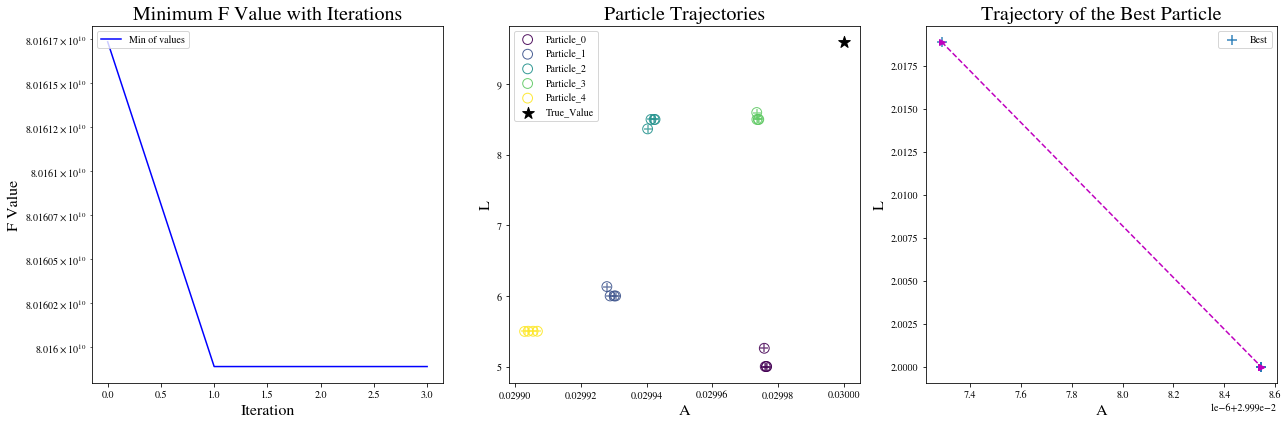

In [27]:
imno.search(dat="test")

In [16]:
import torch
import torch.nn as nn
import numpy as np

# Assuming the mse and other functions and models are defined correctly
mse = nn.MSELoss()
train_input_data = train_input_data.cuda()  # Send to GPU once if it's static

for i in np.arange(0, 10, 0.5):
    conditions = torch.tensor([0.000, i], dtype=torch.float32).reshape(1,2).cuda()
    # Ensure the models and methods used below are correctly defined and utilized
    decoded_output = gt_normalizer.decode(imno.net(train_input_data, conditions)).detach().cpu()
    # plt.ion()
    # plt.imshow(decoded_output[0,:,0,:],vmin=0,vmax=0.05)
    # plt.show()
    # plt.imshow(train_g_t[0,:,0,:],vmin=0,vmax=0.05)
    # plt.show()
    error = mse(decoded_output, train_g_t)*1e8 
    print(f"i: {i:.2f}, Error: {error.item()}")


i: 0.00, Error: 1.0069632530212402
i: 0.50, Error: 1.006945252418518
i: 1.00, Error: 1.006919264793396
i: 1.50, Error: 1.006881594657898
i: 2.00, Error: 1.0068278312683105
i: 2.50, Error: 1.0067461729049683
i: 3.00, Error: 1.006630539894104
i: 3.50, Error: 1.0064610242843628
i: 4.00, Error: 1.0062183141708374
i: 4.50, Error: 1.0058720111846924
i: 5.00, Error: 1.0053848028182983
i: 5.50, Error: 1.0047193765640259
i: 6.00, Error: 1.0038384199142456
i: 6.50, Error: 1.0027194023132324
i: 7.00, Error: 1.0013636350631714
i: 7.50, Error: 0.9997982978820801
i: 8.00, Error: 0.9980705976486206
i: 8.50, Error: 0.9962365031242371
i: 9.00, Error: 0.9943496584892273
i: 9.50, Error: 0.9924497008323669


In [ ]:
import numpy as np

# 加载 .npz 文件
data = np.load("/liujinxin/lam/OE/Inverse/Innverse_Out/test/t1.npz", allow_pickle=True)

# 将 KeysView 对象转换为列表并打印出来
print("Keys in the npz file:", list(data.keys()))


data['positions'].shape

data['objectives'].shape

In [ ]:
data['positions']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# 假设 model 已经定义和训练

# 生成用于绘图的网格
x = np.linspace(0.01, 0.03, 100)
y = np.linspace(0, 10, 100)
x, y = np.meshgrid(x, y)
xy = torch.FloatTensor(np.stack([x.ravel(), y.ravel()], axis=1))

# 预测 z 值
imno.branch_net.eval()
with torch.no_grad():
    z = imno.net.bran_nn(xy).numpy().reshape(x.shape)

# 绘制
fig = plt.figure(figsize=(15, 8))

# 添加3D表面图
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Surface plot of z = f(x, y)')

# 添加等值线图
ax2 = fig.add_subplot(122)
contour = ax2.contour(x, y, z, 50, cmap='viridis')  # 50等高线级数
fig.colorbar(contour, ax=ax2, shrink=0.5, aspect=5)  # 添加颜色条
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_title('Contour plot of z = f(x, y)')

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()


In [ ]:
model